In [1]:
# 1. Imports
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


In [5]:
# 2. Load raw data
card_app = pd.read_csv("C:/Users/admin/Desktop/ML/Data/Card_application.csv")
card_credit = pd.read_csv("C:/Users/admin/Desktop/ML/Data/Card_credit.csv")

card_app.shape, card_credit.shape


((438557, 18), (1048575, 3))

In [7]:
card_app.head()
card_credit.head()


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [8]:
# 3. Create target and history features from card_credit

# Flags per month
card_credit["bad"] = card_credit["STATUS"].isin(["2", "3", "4", "5"]).astype(int)
card_credit["late"] = card_credit["STATUS"].isin(["1"]).astype(int)

# Aggregate to customer level
credit_agg = (
    card_credit
    .groupby("ID")
    .agg(
        max_bad=("bad", "max"),          # target: any serious delinquency
        any_late=("late", "max"),        # had minor delay (status 1)
        months_on_book=("MONTHS_BALANCE", "nunique"),
        min_month=("MONTHS_BALANCE", "min"),  # how far back history goes
        max_month=("MONTHS_BALANCE", "max")   # should be 0 for most
    )
    .reset_index()
)

credit_agg.head()
credit_agg["max_bad"].value_counts()


0    45318
1      667
Name: max_bad, dtype: int64

In [9]:
# 4. Merge to build the modelling dataset
data = card_app.merge(credit_agg, on="ID", how="inner")

data.shape
data.head()


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,max_bad,any_late,months_on_book,min_month,max_month
0,5008804,M,Y,Y,0,"427,500.00",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,0,1,16,-15,0
1,5008805,M,Y,Y,0,"427,500.00",Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.00,0,1,15,-14,0
2,5008806,M,Y,Y,0,"112,500.00",Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00,0,0,30,-29,0
3,5008808,F,N,Y,0,"270,000.00",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0,0,5,-4,0
4,5008809,F,N,Y,0,"270,000.00",Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0,0,5,-26,-22


In [10]:
data["max_bad"].value_counts(dropna=False)
data["max_bad"].value_counts(normalize=True) * 100


0   98.31
1    1.69
Name: max_bad, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

<Axes: title={'center': 'Target distribution (max_bad)'}>

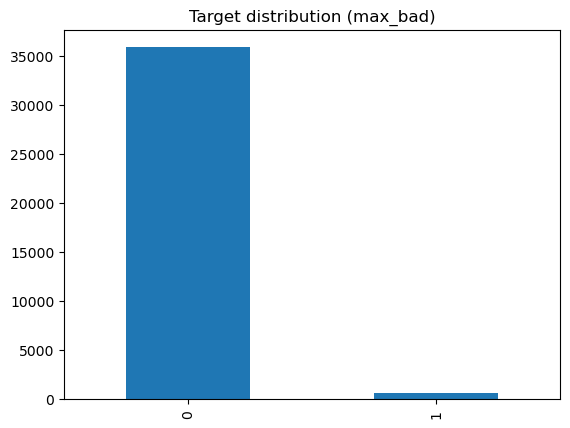

In [11]:
# 5. Basic info
data.info()

# 6. Missing values
data.isna().sum().sort_values(ascending=False)

# 7. Numeric summary
data.describe()

# 8. Simple target vs count
data["max_bad"].value_counts().plot(kind="bar", title="Target distribution (max_bad)")


In [12]:
# 2.1 Create a continuous risk score for regression

data["risk_score"] = (
    1.0 * data["any_late"] +
    2.0 * data["max_bad"] +
    0.02 * data["months_on_book"]
)

data[["ID", "any_late", "max_bad", "months_on_book", "risk_score"]].head(10)


,ID,any_late,max_bad,months_on_book,risk_score
0,5008804,1,0,16,1.32
1,5008805,1,0,15,1.30
2,5008806,0,0,30,0.60
3,5008808,0,0,5,0.10
4,5008809,0,0,5,0.10
5,5008810,0,0,27,0.54
6,5008811,0,0,39,0.78
7,5008812,0,0,17,0.34
8,5008813,0,0,17,0.34
9,5008814,0,0,17,0.34


<Axes: title={'center': 'Risk Score Distribution'}, ylabel='Frequency'>

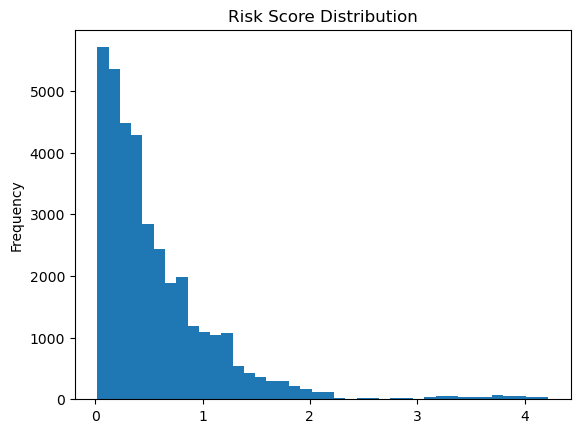

In [13]:
data["risk_score"].describe()
data["risk_score"].plot(kind="hist", bins=40, title="Risk Score Distribution")


C:\Users\admin\AppData\Local\Temp\ipykernel_14840\995831534.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="coolwarm", annot=False)


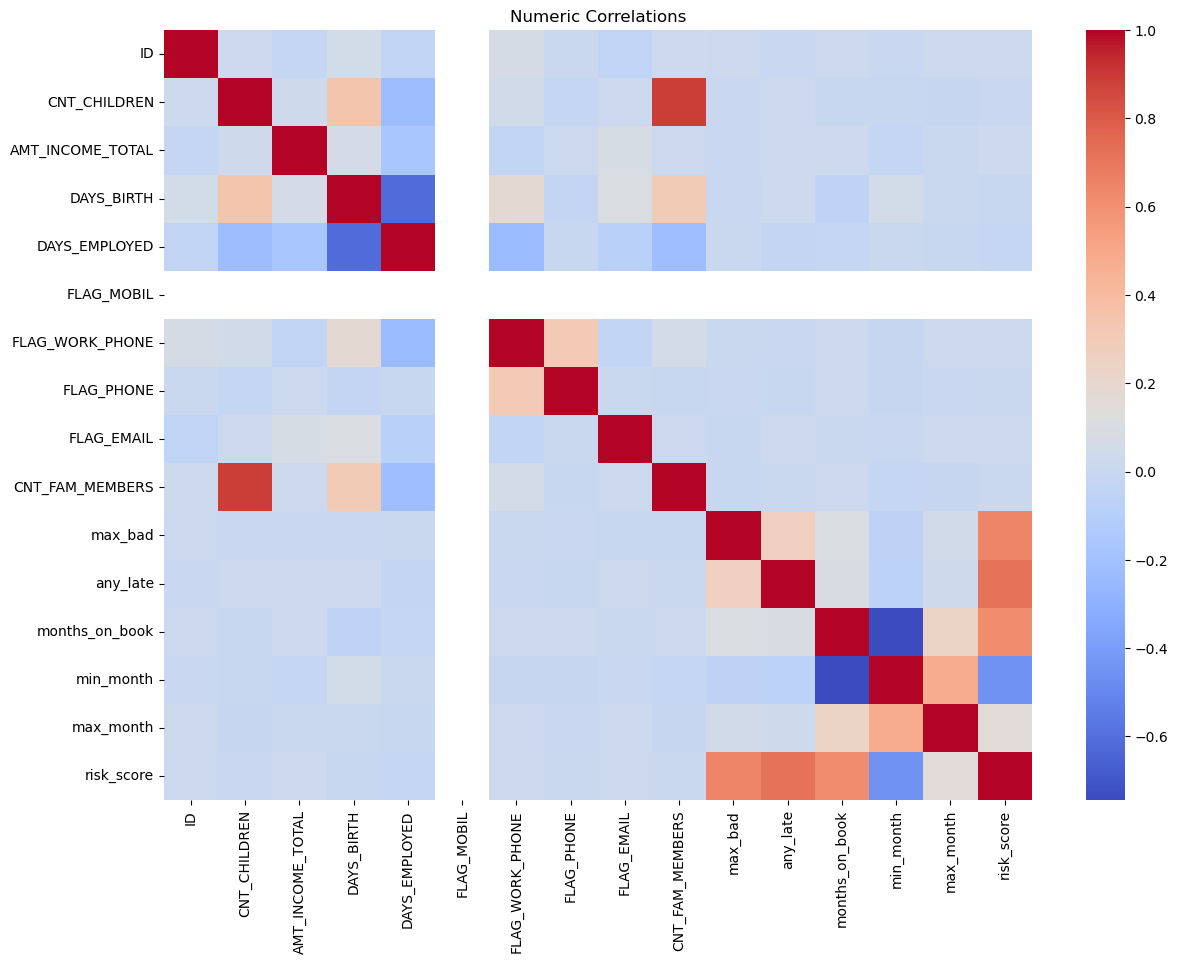

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
sns.heatmap(data.corr(), cmap="coolwarm", annot=False)
plt.title("Numeric Correlations")
plt.show()


In [15]:
categoricals = [
    "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY",
    "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE", "OCCUPATION_TYPE"
]

for col in categoricals:
    print(f"\n=== {col} ===")
    print(data[col].value_counts(dropna=False))



=== CODE_GENDER ===
F    24430
M    12027
Name: CODE_GENDER, dtype: int64

=== FLAG_OWN_CAR ===
N    22614
Y    13843
Name: FLAG_OWN_CAR, dtype: int64

=== FLAG_OWN_REALTY ===
Y    24506
N    11951
Name: FLAG_OWN_REALTY, dtype: int64

=== NAME_INCOME_TYPE ===
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64

=== NAME_EDUCATION_TYPE ===
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64

=== NAME_FAMILY_STATUS ===
Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64

=== NAME_HOUSING_TYPE ===
House / apartment      32548
With parents   

<Axes: xlabel='max_bad', ylabel='risk_score'>

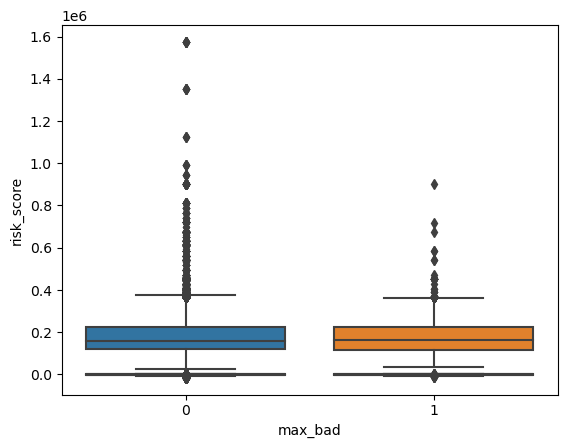

In [16]:
sns.boxplot(data=data, x="max_bad", y="AMT_INCOME_TOTAL")
sns.boxplot(data=data, x="max_bad", y="DAYS_EMPLOYED")
sns.boxplot(data=data, x="max_bad", y="risk_score")


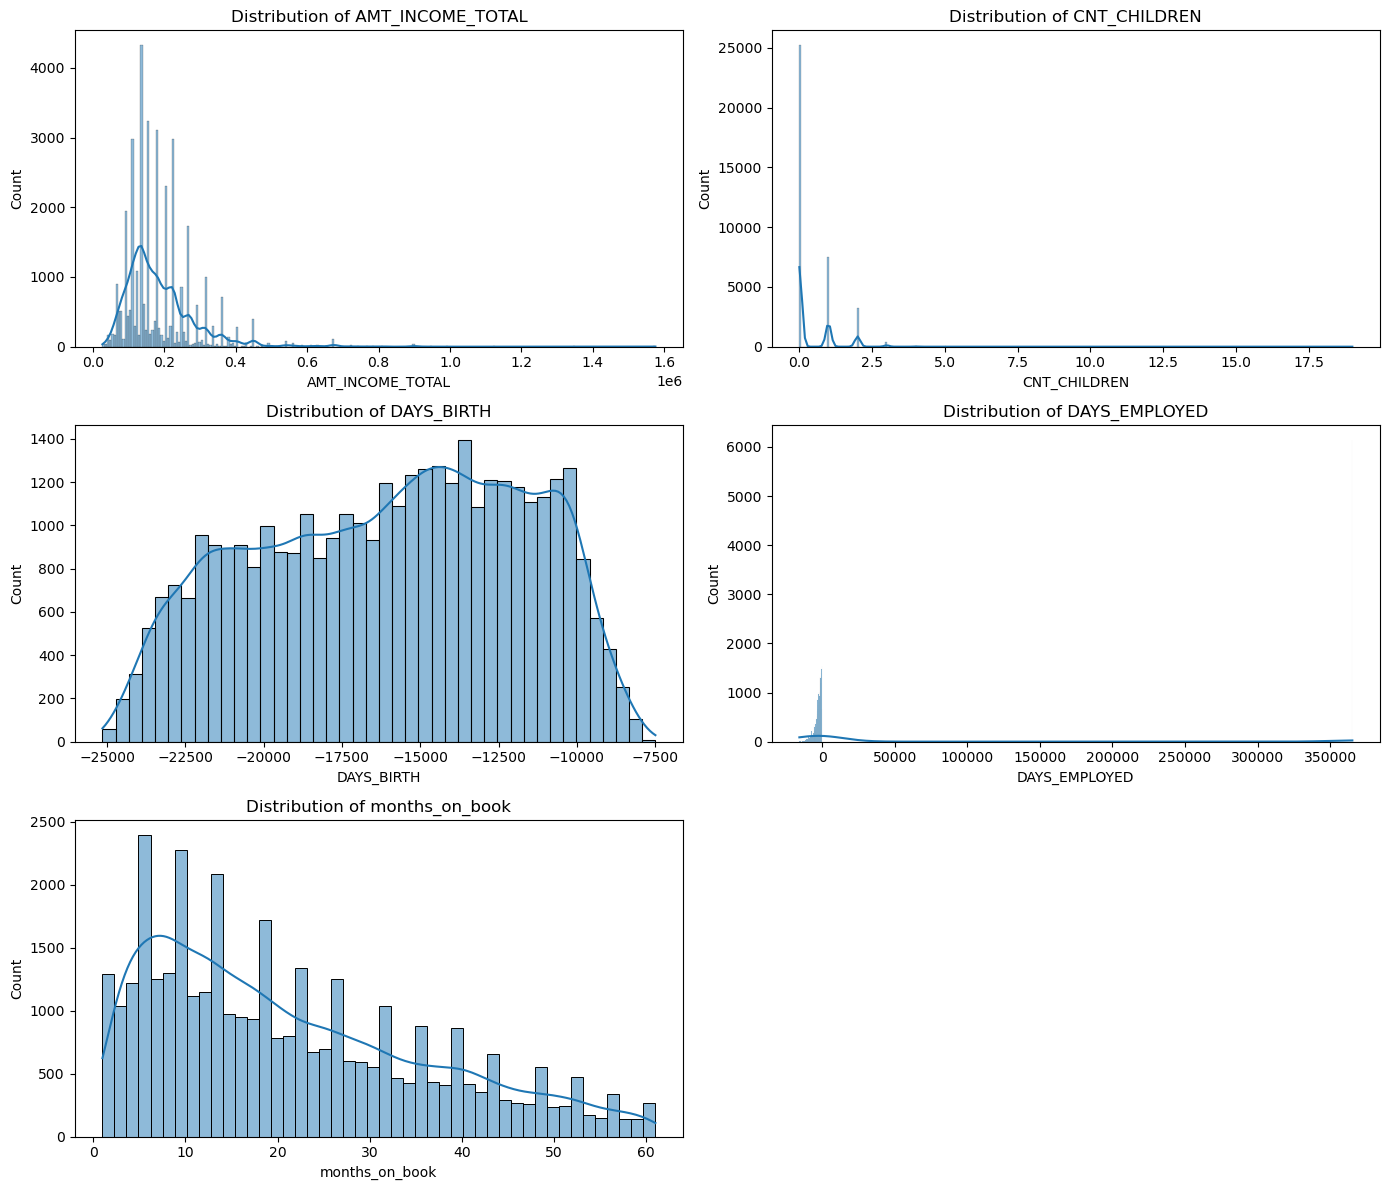

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = [
    "AMT_INCOME_TOTAL", "CNT_CHILDREN", "DAYS_BIRTH",
    "DAYS_EMPLOYED", "months_on_book"
]

plt.figure(figsize=(14, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

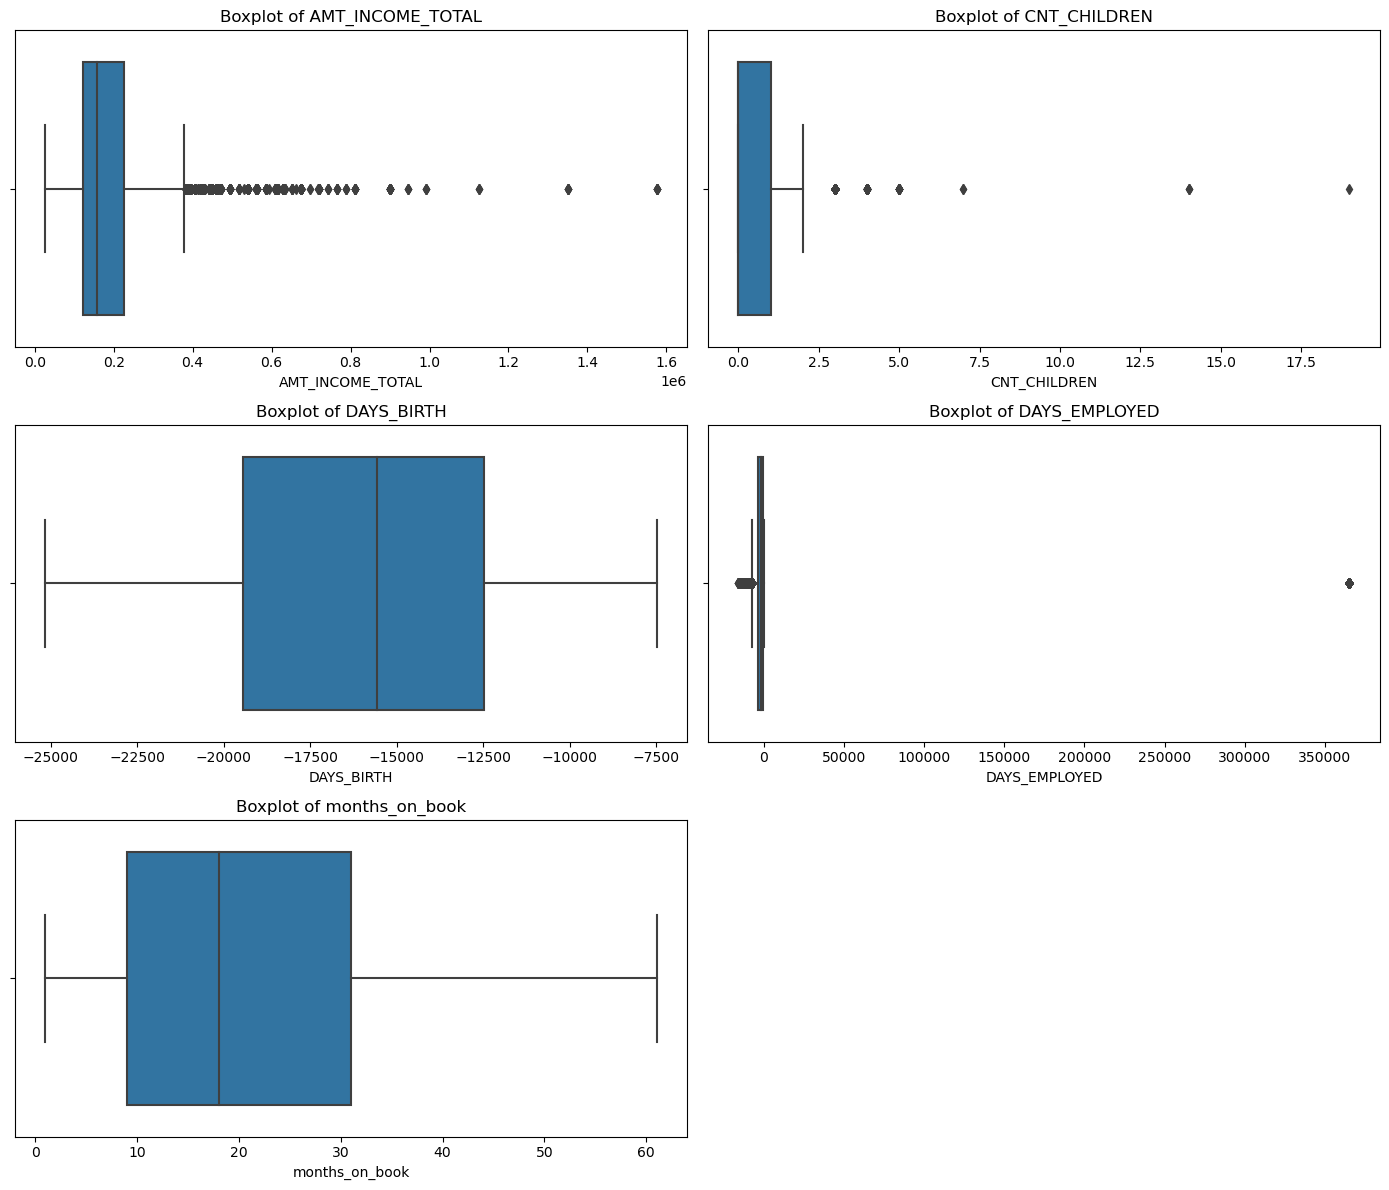

In [43]:
plt.figure(figsize=(14, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


In [17]:
data.corr()["risk_score"].sort_values(ascending=False)


C:\Users\admin\AppData\Local\Temp\ipykernel_14840\70449046.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()["risk_score"].sort_values(ascending=False)


risk_score          1.00
any_late            0.72
max_bad             0.65
months_on_book      0.62
max_month           0.16
AMT_INCOME_TOTAL    0.03
ID                  0.02
FLAG_EMAIL          0.02
FLAG_WORK_PHONE     0.01
CNT_FAM_MEMBERS     0.01
FLAG_PHONE          0.01
CNT_CHILDREN        0.00
DAYS_BIRTH         -0.01
DAYS_EMPLOYED      -0.02
min_month          -0.45
FLAG_MOBIL           NaN
Name: risk_score, dtype: float64

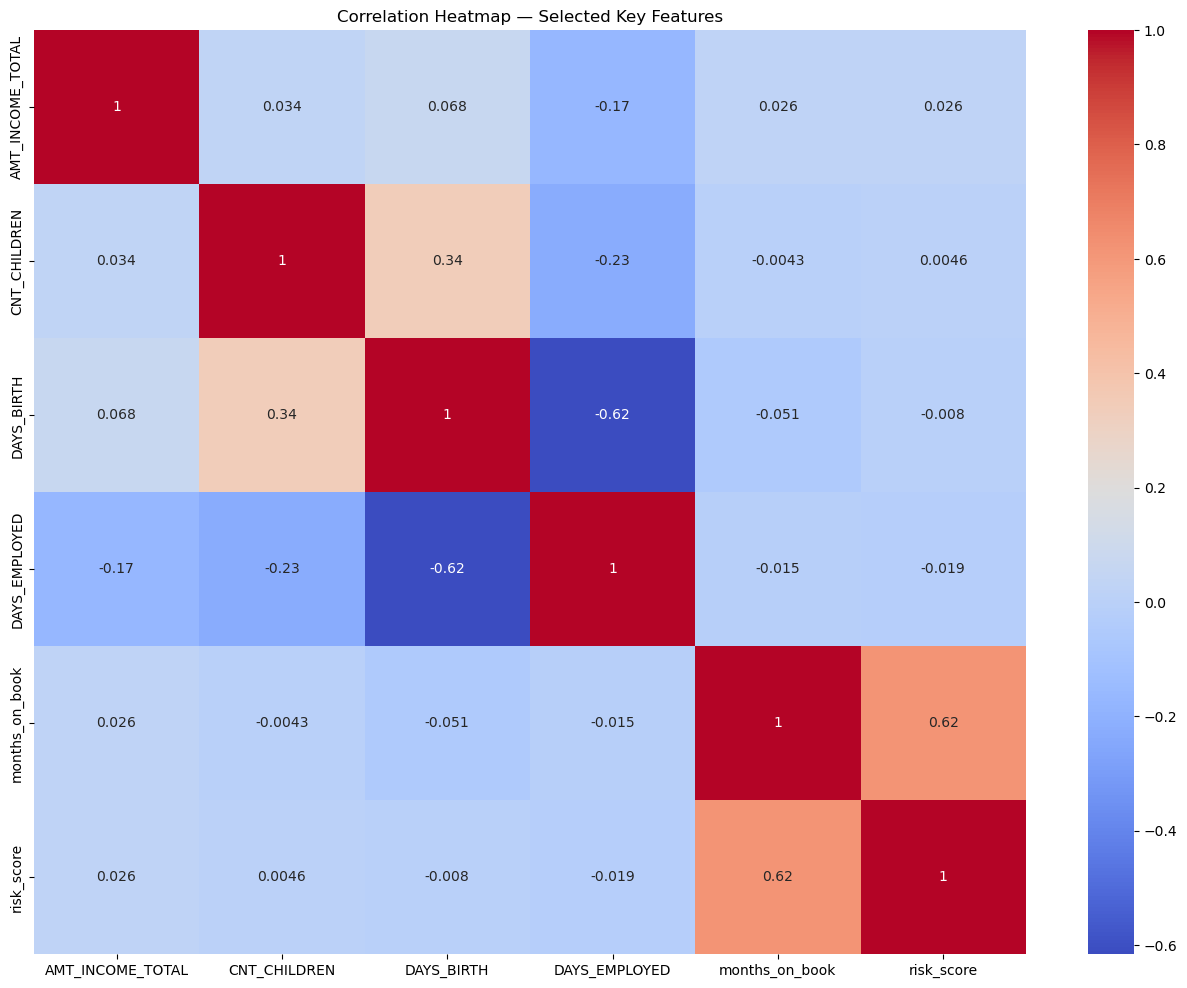

In [44]:
plt.figure(figsize=(16, 12))
sns.heatmap(data[num_cols + ['risk_score']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap — Selected Key Features")
plt.show()


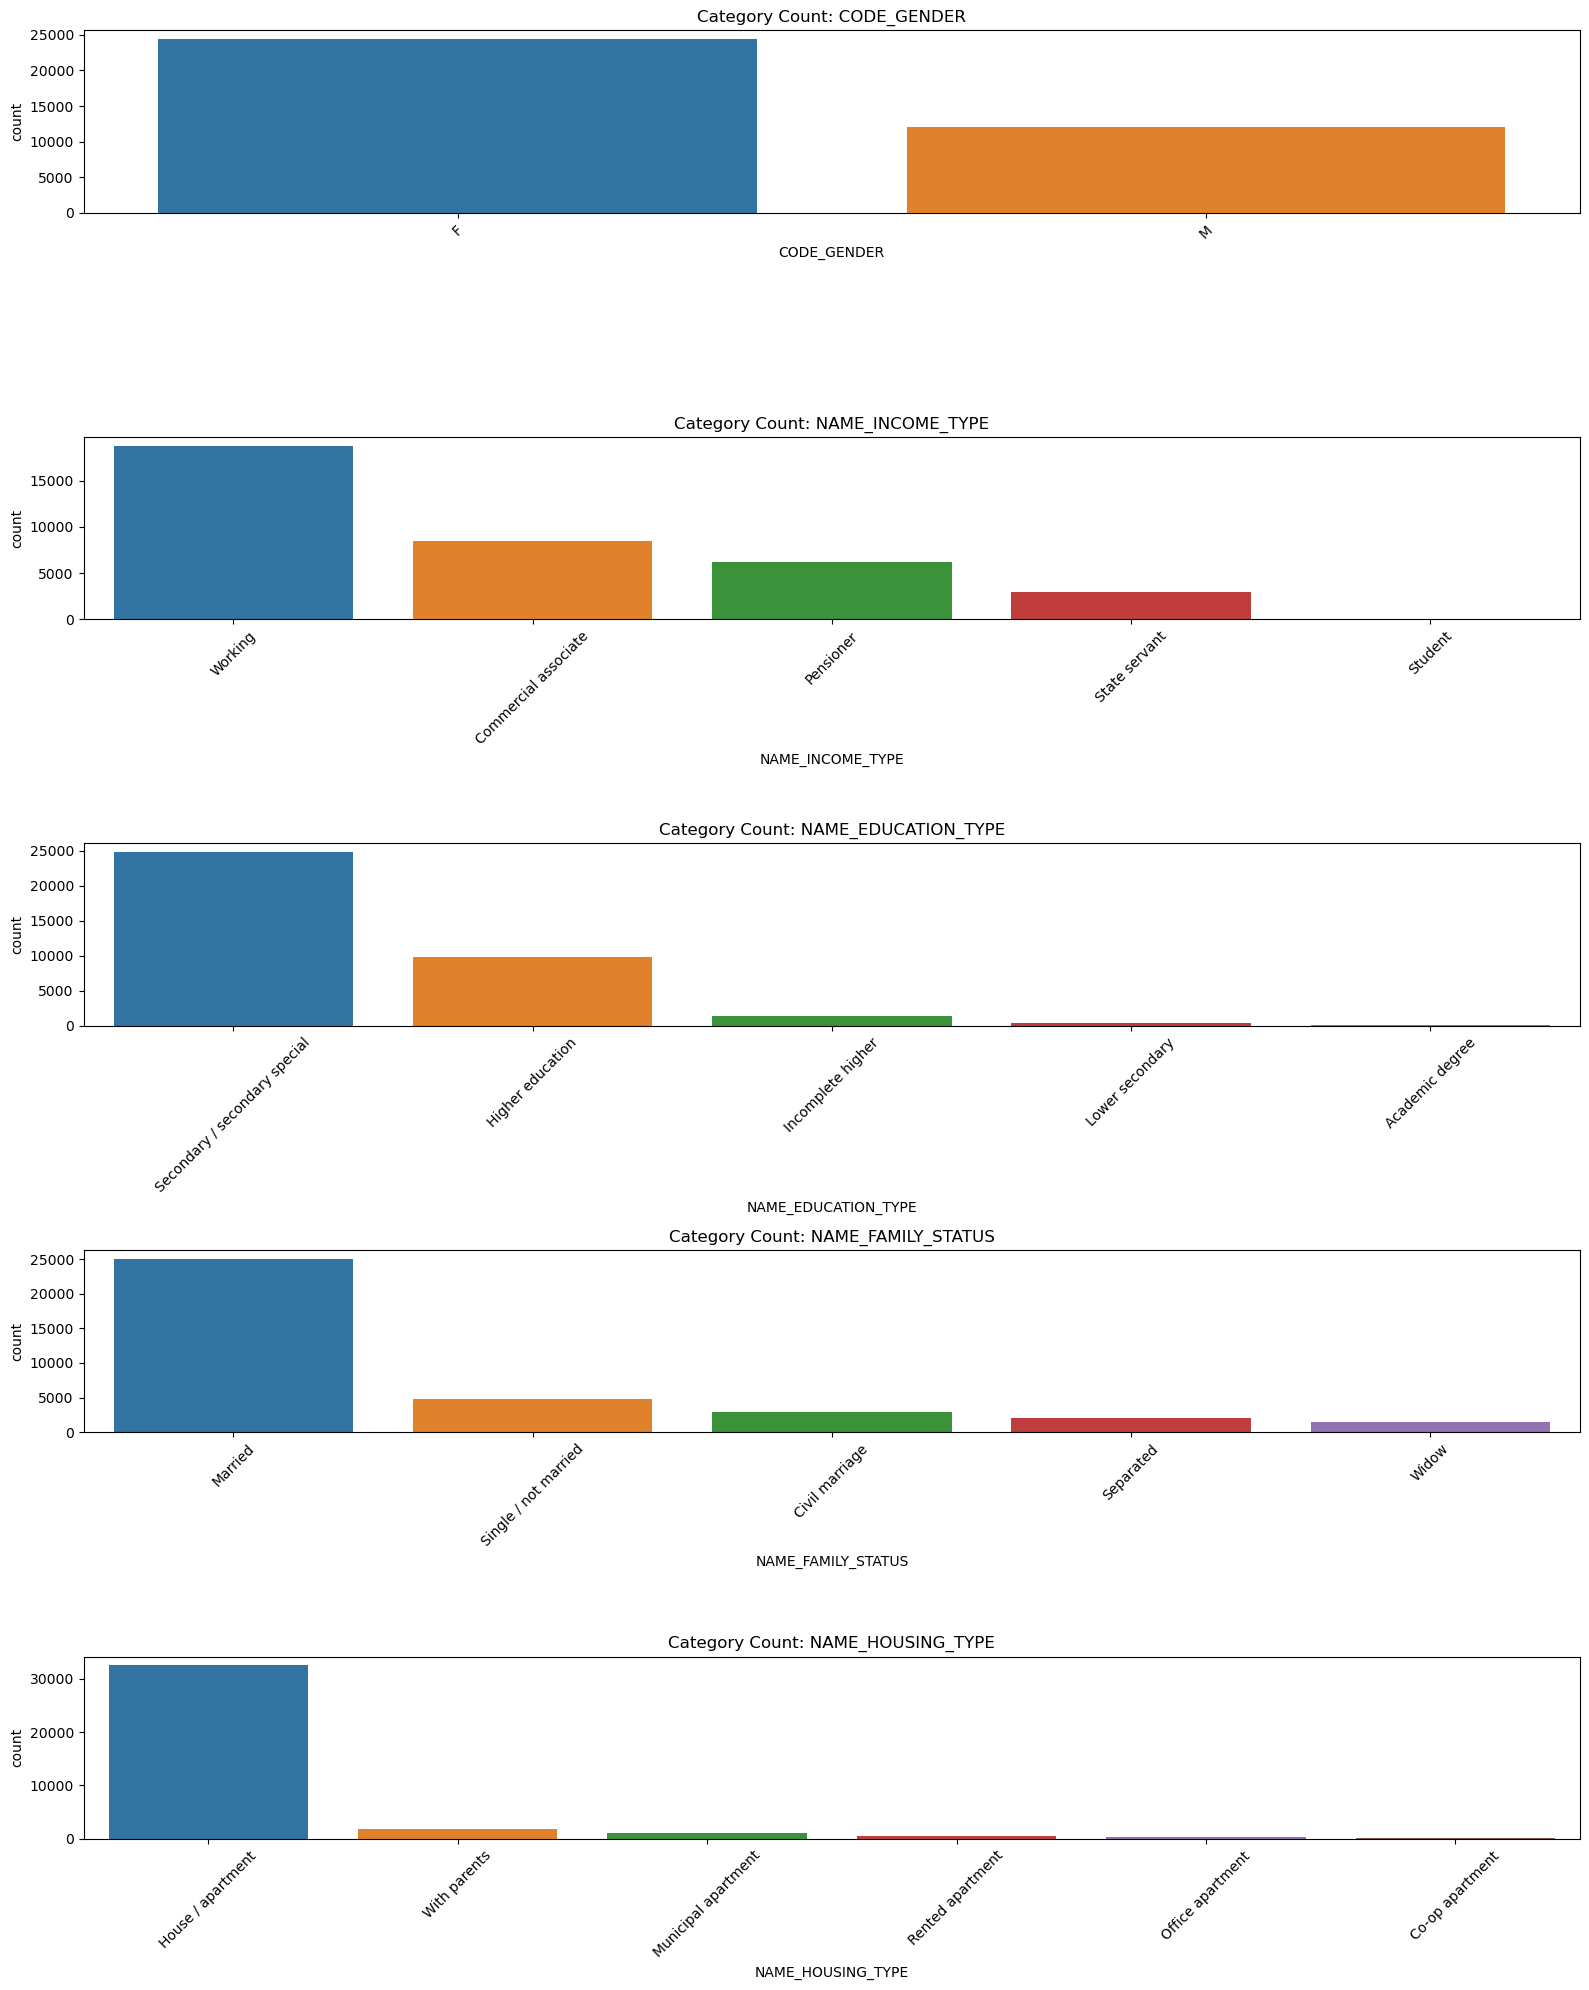

In [45]:
cat_cols = [
    "CODE_GENDER", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"
]

plt.figure(figsize=(16, 20))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(5, 1, i)
    sns.countplot(data=data, x=col, order=data[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Category Count: {col}")
plt.tight_layout()
plt.show()


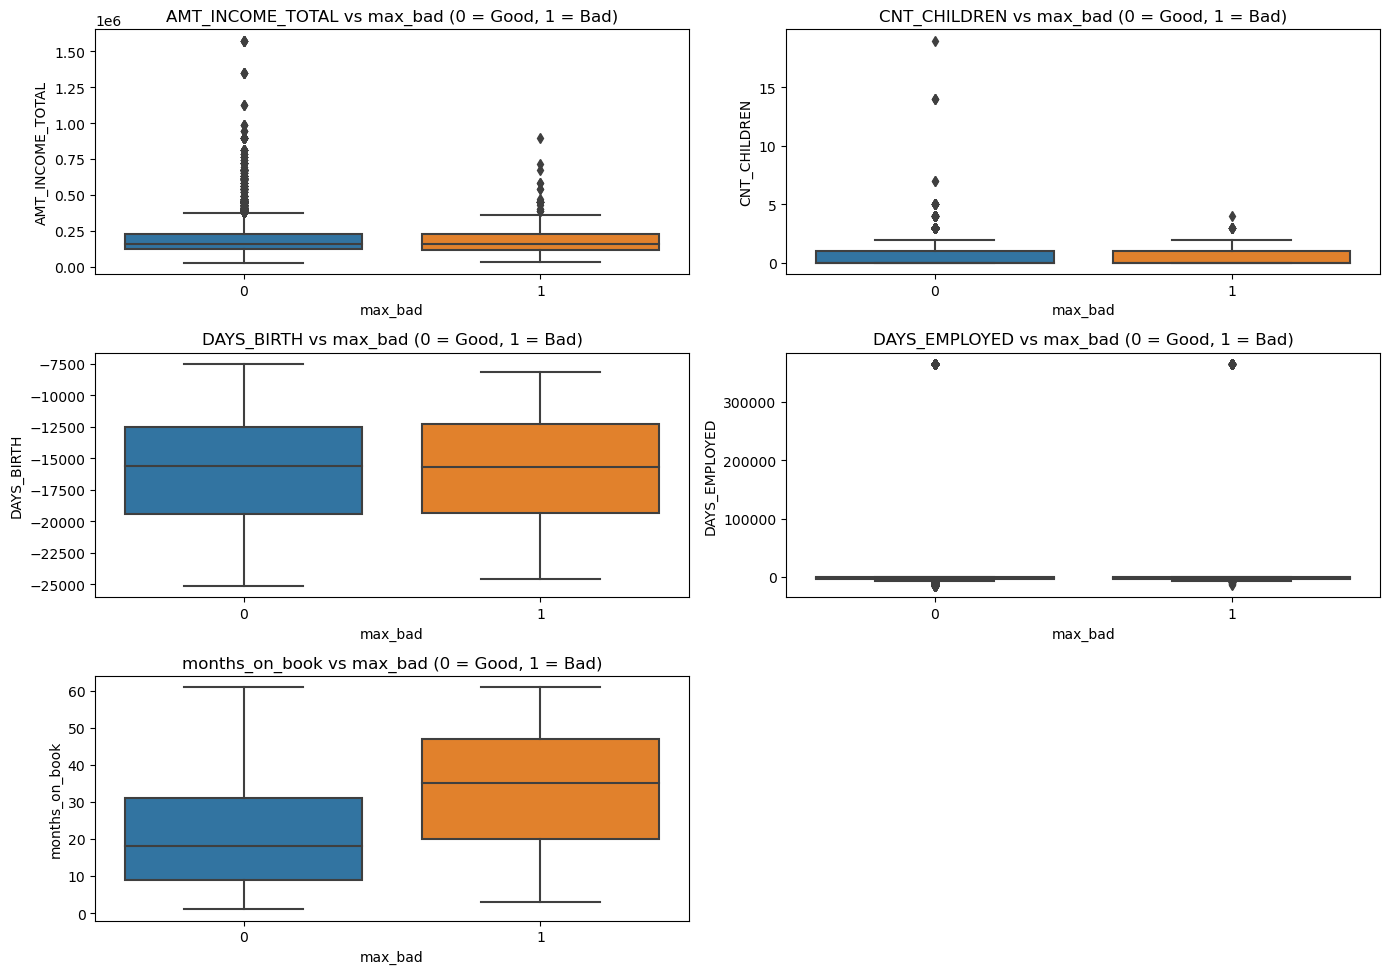

In [46]:
plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x=data["max_bad"], y=data[col])
    plt.title(f"{col} vs max_bad (0 = Good, 1 = Bad)")
plt.tight_layout()
plt.show()


In [47]:
pivot1 = pd.pivot_table(
    data,
    values="AMT_INCOME_TOTAL",
    index="NAME_INCOME_TYPE",
    columns="NAME_FAMILY_STATUS",
    aggfunc="mean"
).round(2)

pivot1


NAME_FAMILY_STATUS,Civil marriage,Married,Separated,Single / not married,Widow
NAME_INCOME_TYPE,,,,,
Commercial associate,"205,184.51","217,625.92","230,361.19","226,657.11","191,544.83"
Pensioner,"164,168.73","145,765.86","148,116.52","158,137.65","149,483.97"
State servant,"180,233.77","207,041.14","189,805.56","200,340.45","222,014.85"
Student,"112,500.00","171,000.00",NaN,"135,000.00",NaN
Working,"174,594.24","182,378.23","189,318.30","182,689.80","181,881.55"


In [48]:
pivot2 = pd.pivot_table(
    data,
    values="DAYS_EMPLOYED",
    index="NAME_EDUCATION_TYPE",
    aggfunc=["mean", "median", "count"]
).round(2)

pivot2


,mean,median,count
,DAYS_EMPLOYED,DAYS_EMPLOYED,DAYS_EMPLOYED
NAME_EDUCATION_TYPE,,,
Academic degree,"9,493.56",-979,32
Higher education,"34,958.87",-1682,9864
Incomplete higher,"12,965.12",-1653,1410
Lower secondary,"155,022.79",-486,374
Secondary / secondary special,"70,192.17",-1472,24777


In [18]:
# List numeric vs categorical
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()

# Remove target columns from numeric list
numeric_cols = [col for col in numeric_cols if col not in ["max_bad", "risk_score"]]

# Fill missing values
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())
data[categorical_cols] = data[categorical_cols].fillna("Unknown")


In [19]:
data.isna().sum().sum()


0

In [20]:
data_encoded = pd.get_dummies(data, columns=categorical_cols, drop_first=True)
data_encoded.shape


(36457, 54)

In [21]:
from sklearn.model_selection import train_test_split

# Features
X = data_encoded.drop(columns=["max_bad", "risk_score"])

# Targets
y_class = data_encoded["max_bad"]
y_reg = data_encoded["risk_score"]

# Split for classification (stratification keeps imbalance structure)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Split for regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_c.shape, X_train_r.shape


((29165, 52), (29165, 52))

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data
X_train_c_scaled = scaler.fit_transform(X_train_c)
X_test_c_scaled = scaler.transform(X_test_c)

X_train_r_scaled = scaler.fit_transform(X_train_r)
X_test_r_scaled = scaler.transform(X_test_r)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

log_clf = LogisticRegression(max_iter=2000, class_weight="balanced")
log_clf.fit(X_train_c_scaled, y_train_c)

y_pred_log = log_clf.predict(X_test_c_scaled)
y_proba_log = log_clf.predict_proba(X_test_c_scaled)[:, 1]

print("=== Logistic Regression Classification Report ===")
print(classification_report(y_test_c, y_pred_log))

print("\nROC-AUC:", roc_auc_score(y_test_c, y_proba_log))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_c, y_pred_log))


=== Logistic Regression Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7169
           1       0.09      0.72      0.16       123

    accuracy                           0.88      7292
   macro avg       0.54      0.80      0.55      7292
weighted avg       0.98      0.88      0.92      7292


ROC-AUC: 0.869945916644269

Confusion Matrix:
[[6297  872]
 [  34   89]]


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42
)

rf_clf.fit(X_train_c, y_train_c)

y_pred_rf = rf_clf.predict(X_test_c)
y_proba_rf = rf_clf.predict_proba(X_test_c)[:, 1]

print("=== Random Forest Classification Report ===")
print(classification_report(y_test_c, y_pred_rf))

print("\nROC-AUC:", roc_auc_score(y_test_c, y_proba_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_c, y_pred_rf))


=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      7169
           1       0.17      0.58      0.26       123

    accuracy                           0.94      7292
   macro avg       0.58      0.76      0.62      7292
weighted avg       0.98      0.94      0.96      7292


ROC-AUC: 0.9031205948828911

Confusion Matrix:
[[6818  351]
 [  52   71]]


In [25]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight= (y_train_c.value_counts()[0] / y_train_c.value_counts()[1])  # imbalance fix
)

xgb_clf.fit(X_train_c, y_train_c)

y_pred_xgb = xgb_clf.predict(X_test_c)
y_proba_xgb = xgb_clf.predict_proba(X_test_c)[:, 1]

print("=== XGBoost Classification Report ===")
print(classification_report(y_test_c, y_pred_xgb))

print("\nROC-AUC:", roc_auc_score(y_test_c, y_proba_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_c, y_pred_xgb))


=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      7169
           1       0.18      0.69      0.29       123

    accuracy                           0.94      7292
   macro avg       0.59      0.82      0.63      7292
weighted avg       0.98      0.94      0.96      7292


ROC-AUC: 0.9077316857699195

Confusion Matrix:
[[6783  386]
 [  38   85]]


In [ ]:
###---4----

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

lin_reg = LinearRegression()
lin_reg.fit(X_train_r_scaled, y_train_r)

y_pred_lin = lin_reg.predict(X_test_r_scaled)

print("=== Linear Regression ===")
print("MSE:", mean_squared_error(y_test_r, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_lin)))
print("MAE:", mean_absolute_error(y_test_r, y_pred_lin))
print("R² Score:", r2_score(y_test_r, y_pred_lin))


=== Linear Regression ===
MSE: 0.056419120837924
RMSE: 0.23752709495534188
MAE: 0.07053869803969515
R² Score: 0.8245839891031501


In [49]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    "n_estimators": [200, 300, 500],
    "max_depth": [8, 12, 16],
    "min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(class_weight="balanced"),
    param_grid=param_grid_rf,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

grid_rf.fit(X_train_c, y_train_c)

print(grid_rf.best_params_)
best_rf_clf = grid_rf.best_estimator_


{'max_depth': 16, 'min_samples_split': 10, 'n_estimators': 200}


In [50]:
param_grid_xgb = {
    "n_estimators": [200, 300, 500],
    "max_depth": [4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(
        eval_metric="logloss",
        scale_pos_weight=(y_train_c.value_counts()[0] / y_train_c.value_counts()[1])
    ),
    param_grid=param_grid_xgb,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1
)

grid_xgb.fit(X_train_c, y_train_c)

print(grid_xgb.best_params_)
best_xgb_clf = grid_xgb.best_estimator_


{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.7}


In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    random_state=42
)

rf_reg.fit(X_train_r, y_train_r)
y_pred_rf_r = rf_reg.predict(X_test_r)

print("=== Random Forest Regressor ===")
print("MSE:", mean_squared_error(y_test_r, y_pred_rf_r))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r)))
print("MAE:", mean_absolute_error(y_test_r, y_pred_rf_r))
print("R² Score:", r2_score(y_test_r, y_pred_rf_r))


=== Random Forest Regressor ===
MSE: 0.054247722713185745
RMSE: 0.23291140528790286
MAE: 0.053559292465705115
R² Score: 0.8313352108778512


In [29]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
)

xgb_reg.fit(X_train_r, y_train_r)
y_pred_xgb_r = xgb_reg.predict(X_test_r)

print("=== XGBoost Regressor ===")
print("MSE:", mean_squared_error(y_test_r, y_pred_xgb_r))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_r)))
print("MAE:", mean_absolute_error(y_test_r, y_pred_xgb_r))
print("R² Score:", r2_score(y_test_r, y_pred_xgb_r))


=== XGBoost Regressor ===
MSE: 0.05105212227889498
RMSE: 0.22594716700789808
MAE: 0.05752019950253322
R² Score: 0.8412708403644193


In [31]:
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

results_class = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test_c, y_pred_log),
        accuracy_score(y_test_c, y_pred_rf),
        accuracy_score(y_test_c, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test_c, y_pred_log, zero_division=0),
        precision_score(y_test_c, y_pred_rf, zero_division=0),
        precision_score(y_test_c, y_pred_xgb, zero_division=0)
    ],
    "Recall": [
        recall_score(y_test_c, y_pred_log),
        recall_score(y_test_c, y_pred_rf),
        recall_score(y_test_c, y_pred_xgb)
    ],
    "F1-Score": [
        f1_score(y_test_c, y_pred_log),
        f1_score(y_test_c, y_pred_rf),
        f1_score(y_test_c, y_pred_xgb)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test_c, y_proba_log),
        roc_auc_score(y_test_c, y_proba_rf),
        roc_auc_score(y_test_c, y_proba_xgb)
    ]
})

results_class


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.88,0.09,0.72,0.16,0.87
1,Random Forest,0.94,0.17,0.58,0.26,0.90
2,XGBoost,0.94,0.18,0.69,0.29,0.91


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

results_class = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test_c, y_pred_log),
        accuracy_score(y_test_c, y_pred_rf),
        accuracy_score(y_test_c, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test_c, y_pred_log, zero_division=0),
        precision_score(y_test_c, y_pred_rf, zero_division=0),
        precision_score(y_test_c, y_pred_xgb, zero_division=0)
    ],
    "Recall": [
        recall_score(y_test_c, y_pred_log),
        recall_score(y_test_c, y_pred_rf),
        recall_score(y_test_c, y_pred_xgb)
    ],
    "F1-Score": [
        f1_score(y_test_c, y_pred_log),
        f1_score(y_test_c, y_pred_rf),
        f1_score(y_test_c, y_pred_xgb)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test_c, y_proba_log),
        roc_auc_score(y_test_c, y_proba_rf),
        roc_auc_score(y_test_c, y_proba_xgb)
    ]
})

results_class


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.88,0.09,0.72,0.16,0.87
1,Random Forest,0.94,0.17,0.58,0.26,0.90
2,XGBoost,0.94,0.18,0.69,0.29,0.91


In [33]:
best_class_model = xgb_clf


In [34]:
results_reg = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest Regressor", "XGBoost Regressor"],
    "MSE": [
        mean_squared_error(y_test_r, y_pred_lin),
        mean_squared_error(y_test_r, y_pred_rf_r),
        mean_squared_error(y_test_r, y_pred_xgb_r)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test_r, y_pred_lin)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_rf_r)),
        np.sqrt(mean_squared_error(y_test_r, y_pred_xgb_r))
    ],
    "MAE": [
        mean_absolute_error(y_test_r, y_pred_lin),
        mean_absolute_error(y_test_r, y_pred_rf_r),
        mean_absolute_error(y_test_r, y_pred_xgb_r)
    ],
    "R2 Score": [
        r2_score(y_test_r, y_pred_lin),
        r2_score(y_test_r, y_pred_rf_r),
        r2_score(y_test_r, y_pred_xgb_r)
    ]
})

results_reg


,Model,MSE,RMSE,MAE,R2 Score
0,Linear Regression,0.06,0.24,0.07,0.82
1,Random Forest Regressor,0.05,0.23,0.05,0.83
2,XGBoost Regressor,0.05,0.23,0.06,0.84


In [35]:
best_reg_model = xgb_reg


In [36]:
importances_class = pd.Series(
    best_class_model.feature_importances_, 
    index=X_train_c.columns
).sort_values(ascending=False)

importances_class.head(20)


any_late                               0.17
OCCUPATION_TYPE_Secretaries            0.05
max_month                              0.03
months_on_book                         0.03
NAME_FAMILY_STATUS_Widow               0.03
NAME_INCOME_TYPE_Pensioner             0.02
OCCUPATION_TYPE_Core staff             0.02
CODE_GENDER_M                          0.02
NAME_INCOME_TYPE_State servant         0.02
OCCUPATION_TYPE_Low-skill Laborers     0.02
NAME_FAMILY_STATUS_Separated           0.02
OCCUPATION_TYPE_Cooking staff          0.02
NAME_EDUCATION_TYPE_Higher education   0.02
AMT_INCOME_TOTAL                       0.02
DAYS_BIRTH                             0.02
ID                                     0.02
FLAG_OWN_CAR_Y                         0.02
DAYS_EMPLOYED                          0.02
OCCUPATION_TYPE_Medicine staff         0.02
NAME_HOUSING_TYPE_Rented apartment     0.02
dtype: float32

<Axes: title={'center': 'Top 20 Features — Classification (XGBoost)'}>

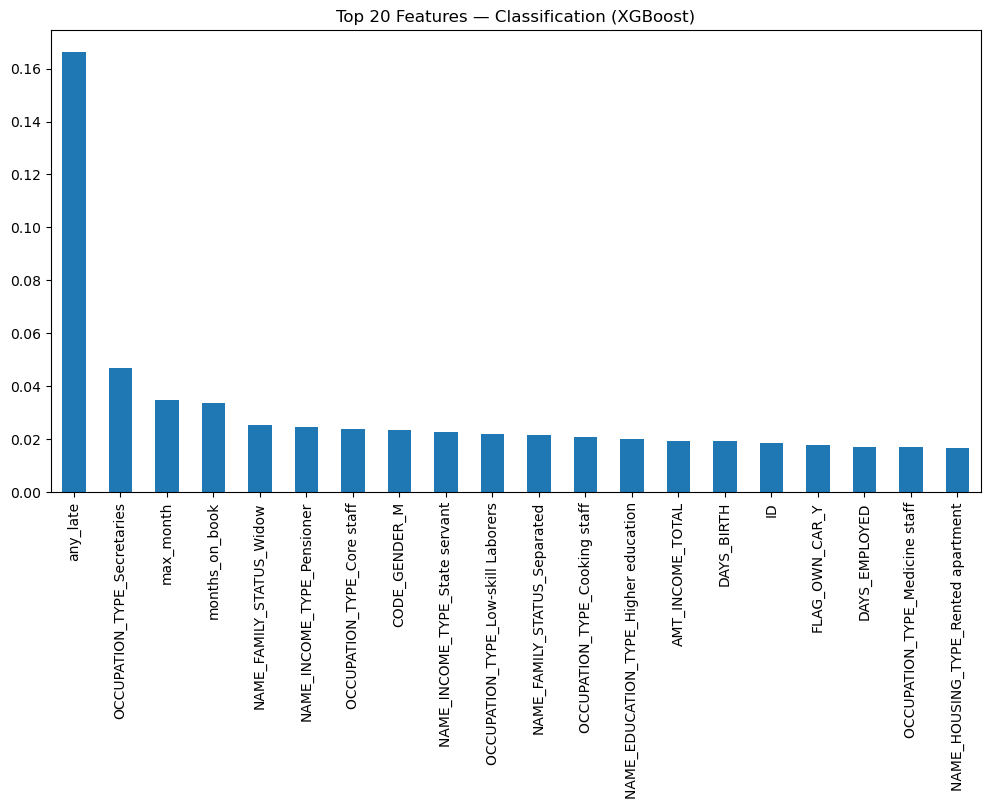

In [37]:
importances_class.head(20).plot(kind="bar", figsize=(12,6), title="Top 20 Features — Classification (XGBoost)")


In [38]:
importances_reg = pd.Series(
    best_reg_model.feature_importances_, 
    index=X_train_r.columns
).sort_values(ascending=False)

importances_reg.head(20)


any_late                                            0.52
months_on_book                                      0.11
min_month                                           0.03
max_month                                           0.02
NAME_EDUCATION_TYPE_Secondary / secondary special   0.02
CNT_CHILDREN                                        0.01
FLAG_WORK_PHONE                                     0.01
NAME_INCOME_TYPE_Pensioner                          0.01
OCCUPATION_TYPE_Laborers                            0.01
OCCUPATION_TYPE_Core staff                          0.01
OCCUPATION_TYPE_Managers                            0.01
OCCUPATION_TYPE_HR staff                            0.01
NAME_FAMILY_STATUS_Separated                        0.01
DAYS_EMPLOYED                                       0.01
NAME_HOUSING_TYPE_With parents                      0.01
OCCUPATION_TYPE_High skill tech staff               0.01
CNT_FAM_MEMBERS                                     0.01
NAME_HOUSING_TYPE_Municipal apa

<Axes: title={'center': 'Top 20 Features — Regression (XGBoost)'}>

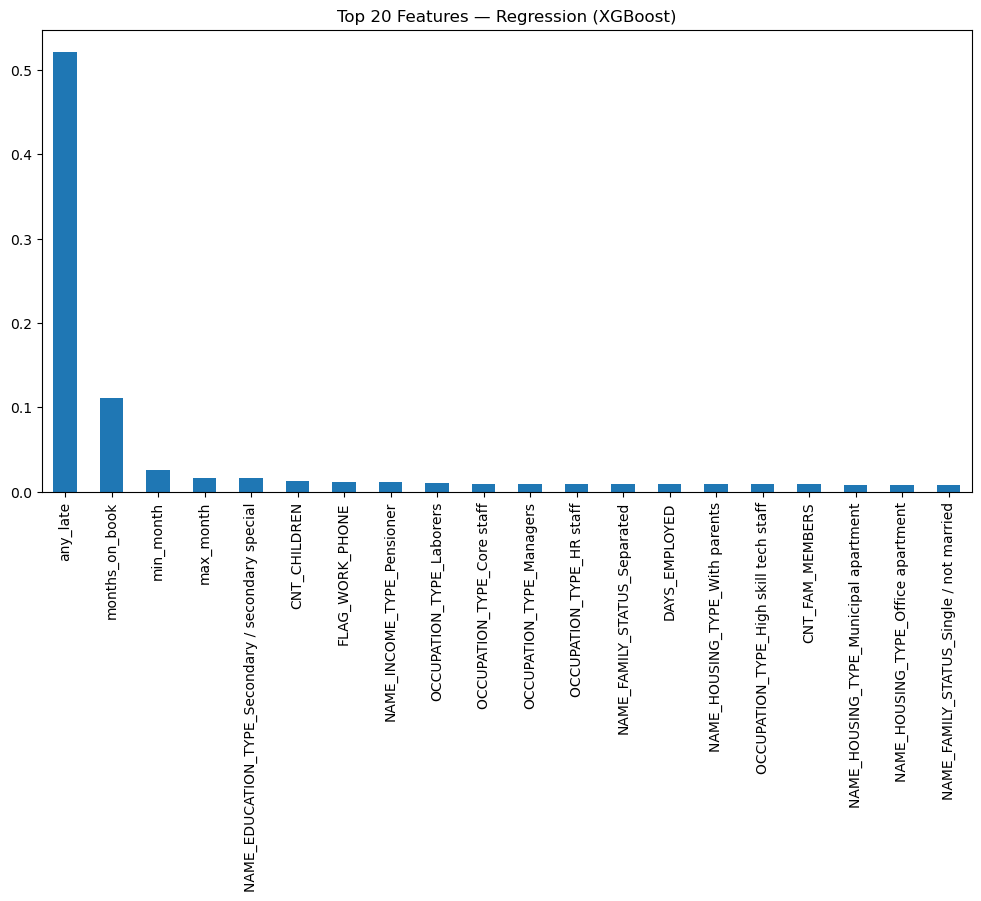

In [39]:
importances_reg.head(20).plot(kind="bar", figsize=(12,6), title="Top 20 Features — Regression (XGBoost)")


In [40]:
def hybrid_predict(input_row):
    """
    input_row: pandas dataframe with 1 row
    returns: classification label, classification probability, regression score
    """
    # Preprocess input
    input_row_encoded = pd.get_dummies(input_row, columns=categorical_cols, drop_first=True)
    input_row_encoded = input_row_encoded.reindex(columns=X_train_c.columns, fill_value=0)
    
    # Classification
    prob = best_class_model.predict_proba(input_row_encoded)[0][1]
    label = "BAD" if prob > 0.5 else "GOOD"
    
    # Regression
    score = best_reg_model.predict(input_row_encoded)[0]
    
    return label, prob, score


In [41]:
sample = data.iloc[[0]].drop(columns=["max_bad", "risk_score"])
hybrid_predict(sample)


('GOOD', 0.12198444, 1.3630756)